This file is associated with Lecture 14

# Loading the Data and Packages

In [1]:
# Let's load some packages we need
import mne
import mne.viz
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import copy
#Load Dataset
subject = 1 # use data from subject 1
runs = [6, 10, 14] # use only hand and feet motor imagery runs
#Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
#Combine all loaded runs
raw_obj = concatenate_raws(raws)
raw_data = raw_obj._data
#Set Standard Channel Locations
eegbci.standardize(raw_obj) # set channel names
montage = make_standard_montage('standard_1005')
raw_obj.set_montage(montage)
#Extract events from raw data
events, event_ids = mne.events_from_annotations(raw_obj, event_id='auto')
tmin, tmax = -1, 4 # define epochs around events (in s)
#event_ids = dict(hands=2, feet=3) # map event IDs to tasks
epochs = mne.Epochs(raw_obj, events, event_ids, tmin - 0.5, tmax + 0.5, baseline=None, preload=True)
# Get sammpling frequency
fs=raw_obj.info['sfreq']

Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
90 ma

## Phase Analysis

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Text(0, 0.5, 'degree in radians')

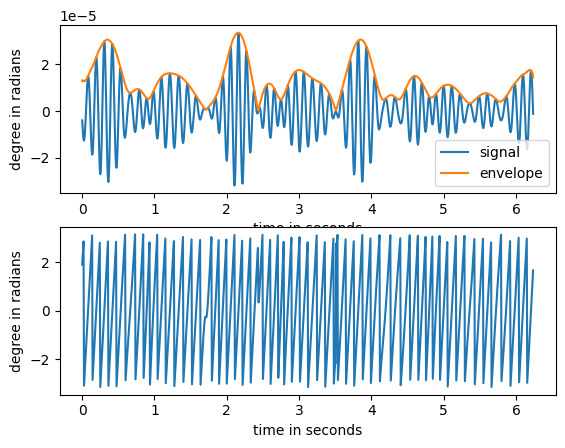

In [6]:
from scipy.signal import hilbert
raw_obj.filter(8., 10.)
raw_data = raw_obj._data[10,1:1000] # channel 10, samples 1 to 1000
N = len(raw_data) # number of samples
t = np.arange(N)/fs # sample spacing
analytic_signal = hilbert(raw_data)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = (np.angle(analytic_signal,deg=False))
fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.plot(t, raw_data, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.set_ylabel("degree in radians")
ax0.legend()
ax1.plot(t, instantaneous_phase)
ax1.set_xlabel("time in seconds")
ax1.set_ylabel("degree in radians")

## Test for Phase Synchrony

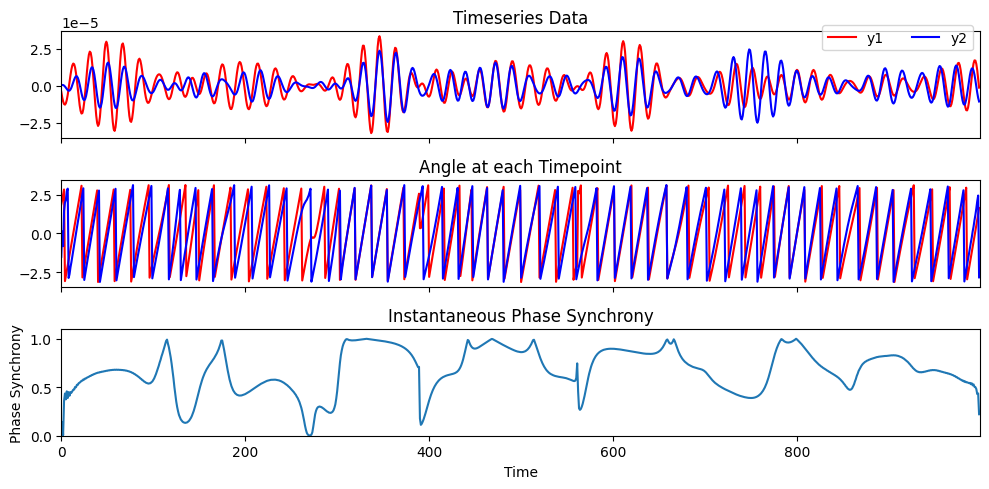

In [8]:
raw_data_1 = raw_obj._data[10,1:1000]
raw_data_2 = raw_obj._data[40,1:1000]
N = len(raw_data_1) # number of samples
t = np.arange(N)/fs # sample spacing
an_sig_1 = hilbert(raw_data_1)
an_sig_2 = hilbert(raw_data_2)
am_env_1 = np.abs(an_sig_1)
am_env_2 = np.abs(an_sig_2)
in_ph_1 = (np.angle(an_sig_1,deg=False))
in_ph_2 = (np.angle(an_sig_2,deg=False))
ph_syn = 1-np.sin(np.abs(in_ph_1-in_ph_2)/2)
f,ax = plt.subplots(3,1,figsize=(10,5),sharex=True)
ax[0].plot(raw_data_1,color='r',label='y1')
ax[0].plot(raw_data_2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Timeseries Data')
ax[1].plot(in_ph_1,color='r')
ax[1].plot(in_ph_2,color='b')
ax[1].set(title='Angle at each Timepoint')
ax[2].plot(ph_syn)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()